# NLP Processing with Disaster Tweets

# Competition description

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies).\
In this task we have to predict whther a tweet is about a real disaster or not

# Importing liraries

In [287]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer , TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from IPython.display import Image

# Data importing and breakdown

In [288]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train info:\n")
print(train.info())
print("\nTestinfo:\n")
print(test.info())

Train info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Testinfo:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


# Data format
Train dataset consists of 7613 rows and 5 columns, whereas the test dataset consists of 3263 rows and 4 columns\
Information in datasets:
* The ```text``` of a tweet
* A ```keyword``` from the tweet (has empty values)
* The ```location``` the tweet was sent from (may have empty values)
* ```ID``` of the tweet
* ```target``` only in train dataset - value weather the tweet is about disaster or not (1 - real disaster, 0 - not)

# EDA
## Missing values in train and test datasets

In [289]:
print("Train missing values:\n")
print(train.isna().sum())
print("Test missing values:\n")
print(test.isna().sum())

Train missing values:

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Test missing values:

id             0
keyword       26
location    1105
text           0
dtype: int64


In [290]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [291]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Concatenate to full dataset for further exploration

In [292]:
full = pd.concat(objs=[train, test], axis=0)
full.tail()#check for correct concat

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


## Distribution of Target

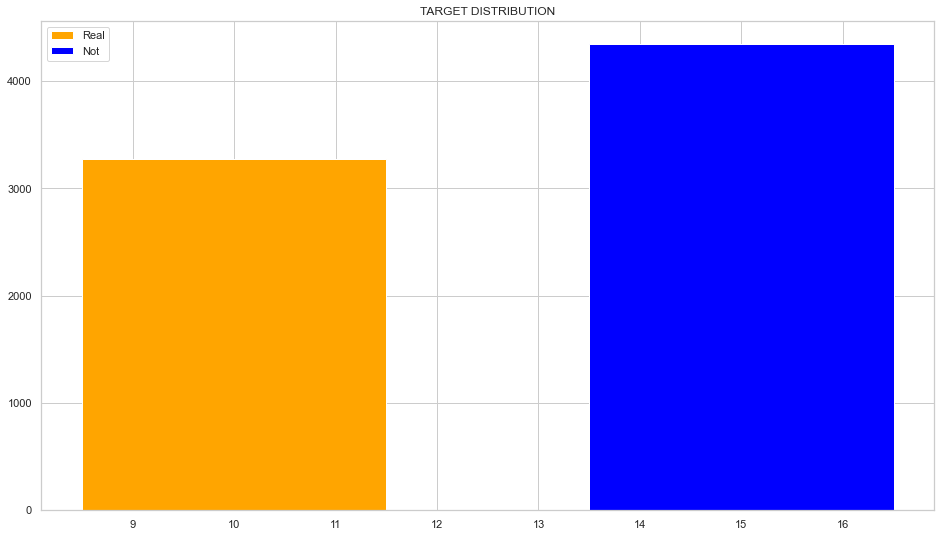

In [293]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.bar(10,full[full['target'] == 1].shape[0],3, label="Real", color='orange')
plt.bar(15,full[full['target'] == 0].shape[0],3, label="Not", color='blue')
plt.legend()
plt.title('TARGET DISTRIBUTION')
plt.show()

Here we can se an imbalance towards the negative class in dataset. This information could have a severe impact on classifier we create. For example, the classifier may be inclined to predict predominant class, which would ,ean higher accuracy. In our case, the imbalance isn’t to serve yet it’s still something worthy of taking notes of.

## Sentence length analysis

In [294]:
def length(string):
    return len(string)
sent_length = full
sent_length['length'] = sent_length['text'].apply(length)
sent_length.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88


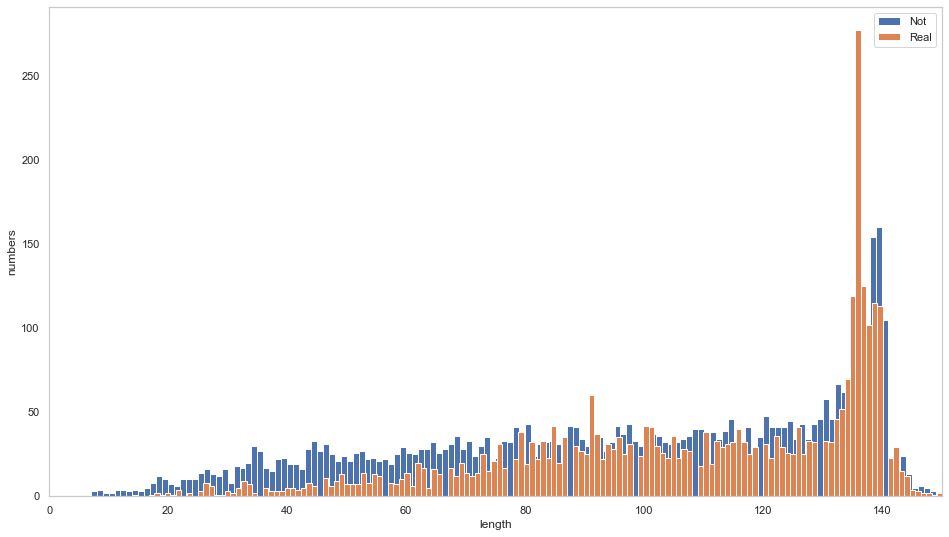

In [295]:
plt.rcParams['figure.figsize'] = (16, 9)
bins = 150
plt.hist(sent_length[sent_length['target'] == 0]['length'], alpha = 1, bins=bins, label='Not')
plt.hist(sent_length[sent_length['target'] == 1]['length'], alpha = 1, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

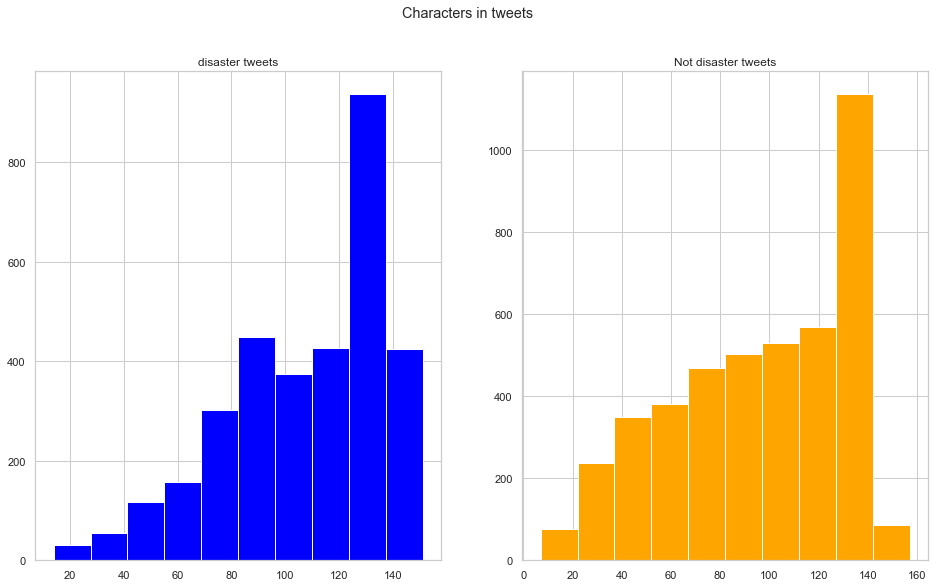

In [296]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16, 9))
tweet_len=sent_length[sent_length['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=sent_length[sent_length['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='orange')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

## Percentage of missing values

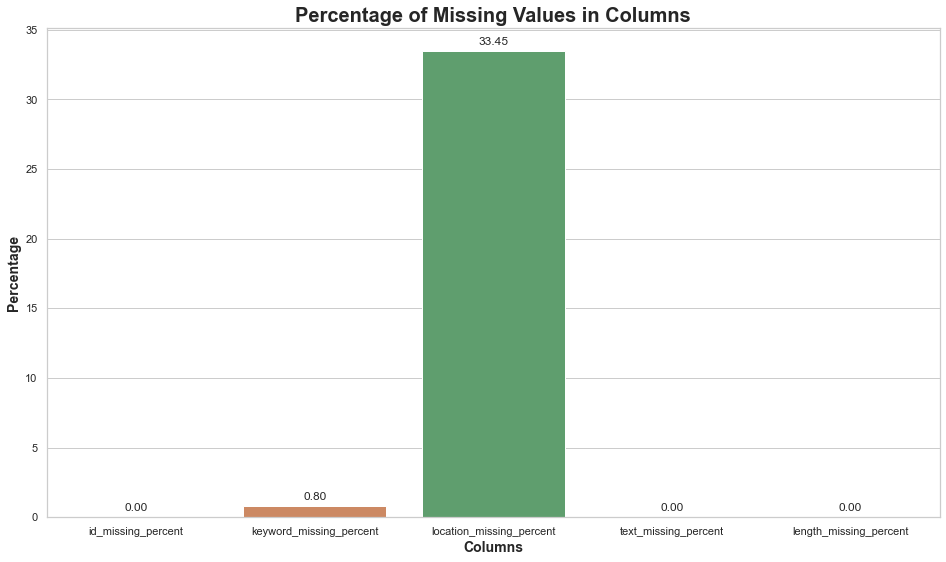

In [297]:
# creating a new dataframe for missing values percentage
missing_values = dict(zip([col+"_missing_percent" for col in full.columns if col != "target"],
                          [round(100*full[col].isnull().sum()/len(full), 2) for col in full.columns
                           if col != "target"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(16, 9))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

33.45% of values in the location column are missing in the training and test set which is quite significant. Since these are locations of tweets and users on Twitter have the option of turning off their location, we could possibly impute something to indicate that the location is missing.

## Unique values

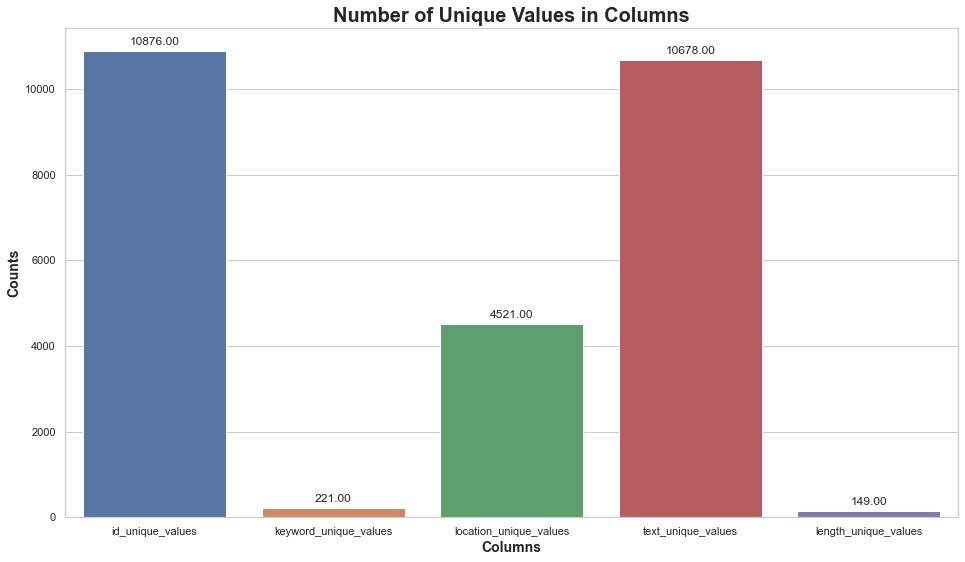

In [298]:
# creating a new dataframe for unique value cound
unique_values = dict(zip([col+"_unique_values" for col in full.columns if col != "target"],
                          [full[col].nunique() for col in full.columns if col != "target"]))
unique_values_df = pd.DataFrame(unique_values, index=[0])
unique_values_df = unique_values_df.melt(var_name= "columns", value_name= "counts")

# plotting unique values chart
plt.figure(figsize=(16, 9))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="counts", data=unique_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Number of Unique Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

So, there are 4521 unique locations, 221 unique keywords\
There are 198 duplicate tweets, lets investigate this

## Duplicate tweets

Since we don’t know how the data was collected or labeled, first thought was to consider whether there are any duplicated tweets in our dataset. Here are the results:

* 198 Duplicated tweets in the train and test data
* 110 of those duplicates are in the training data
* 88 are duplicate tweets from the test data

If there are duplicates in the data then it’s possible that if a human had labeled the instances there could be duplicate labels that were labeled differently. And that thought was right, as we can see here.

In [299]:
# all duplicate tweets
duplicated_df = full[full["text"].duplicated()]

print(f"Number of Duplicated Tweets in Train & Test: {len(duplicated_df)}\n\
Number of Duplicated Tweets in Train: {duplicated_df['target'].notna().sum()}\n\
Number of Duplicated Tweets in Test: {duplicated_df['target'].isna().sum()}\n")

Number of Duplicated Tweets in Train & Test: 198
Number of Duplicated Tweets in Train: 110
Number of Duplicated Tweets in Test: 88



In [300]:
# add all the tweets with duplicates
train_duplicates = train[train["text"].duplicated()].groupby(["text"])[["target"]].agg(list)

diff_label_idx = []
for idx, val in enumerate(train_duplicates["target"]):
    for ele in val: 
        if ele != val[0]:
            diff_label_idx.append(idx)
                
print(f"Number of Duplicated Tweets with different target labels in train: {len(diff_label_idx)}")

Number of Duplicated Tweets with different target labels in train: 12


In [301]:
# tweets with different labels
train_duplicates.iloc[diff_label_idx]

,target
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,"[0, 1]"
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,"[1, 0]"
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,"[1, 0, 1]"
CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,"[1, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,"[1, 0]"
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',"[0, 1, 0, 0, 1]"


## Top locations of tweets

In [302]:
# creating a new dataframe with value counts of each location
locations= full["location"].value_counts().sort_values(ascending=False)
locations_df= pd.DataFrame(dict(zip(locations.index, locations.values)), index=[0]).\
                                melt(var_name="location", value_name="unique_counts")
locations_df.loc[:10]

,location,unique_counts
0,USA,141
1,New York,109
2,United States,65
3,London,58
4,Canada,42
5,Nigeria,40
6,India,35
7,Worldwide,35
8,"Los Angeles, CA",34
9,UK,33


In [303]:
# plotting in a graph 
data = {
    "values": locations_df["unique_counts"].loc[:10],
    "labels": locations_df["location"].loc[:10],
    "domain": {"column": 0},
    "hoverinfo": "label + percent",
    "type": "pie"
}
layout = go.Layout(title= "<b>Top 10 Locations from Tweets</b>",
                   legend= dict(x=0.1, y=1.1, orientation="v"))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

## Keywords

When dealing with text, it’s quite difficult to visualize them on traditional plots. Instead, we could use word clouds to visualize common words that occur in our data. We used this method to visualize the keyword features that are most associated with disasters and those not associated.\
The words that are displayed in the much larger text are the ones that have more frequent counts in the dataset.

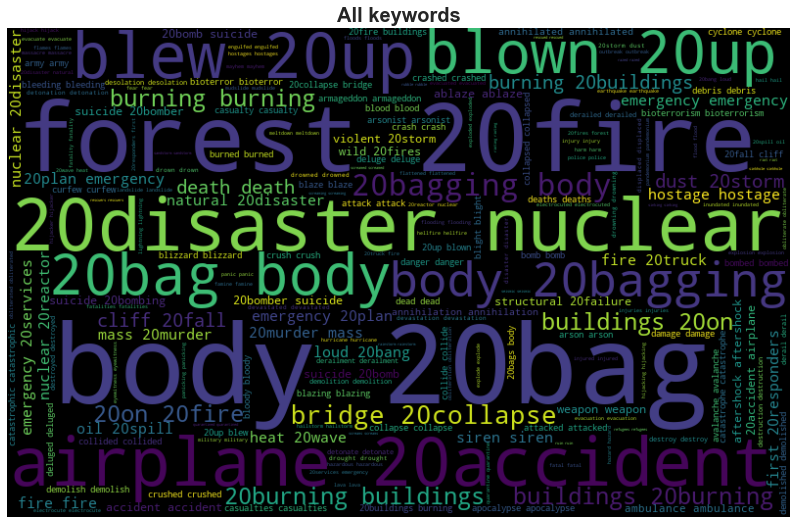

In [304]:
# getting all the keywords from keyword column
all_keywords = " ".join([keyword for keyword in full["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_keywords)

# plotting 
plt.figure(figsize=(16, 9))
plt.title("All keywords", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

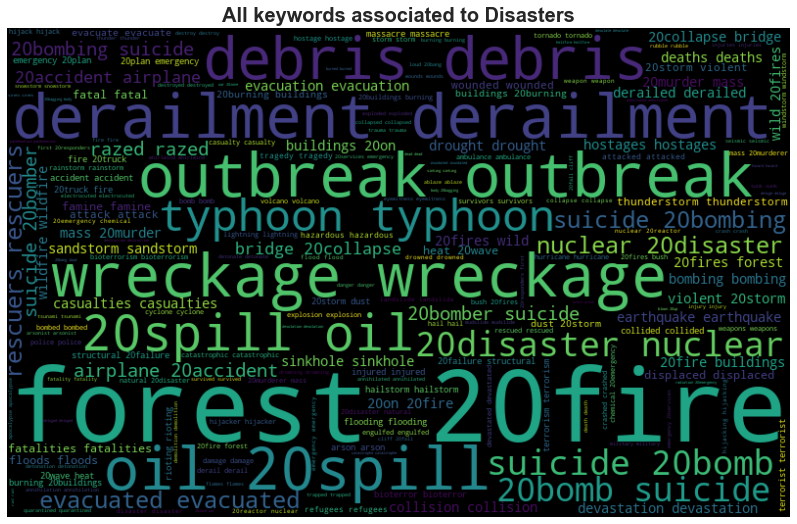

In [305]:
# all keywords from tweets associated to a disaster 
all_disaster_keywords = " ".join([keyword for keyword in full[full["target"]==1]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_disaster_keywords)

# plotting 
plt.figure(figsize=(16, 9))
plt.title("All keywords associated to Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

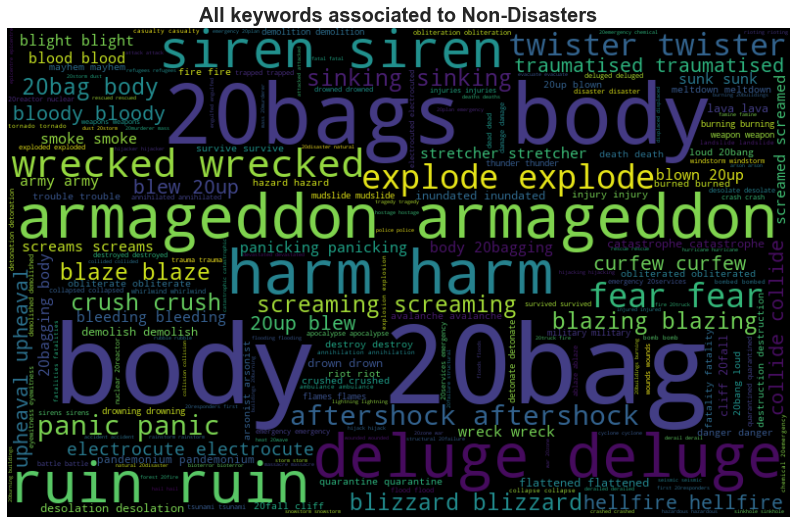

In [306]:
# all keywords from tweets NOT associated to disaster
all_non_disaster_keywords = " ".join([keyword for keyword in full[full["target"]==0]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_non_disaster_keywords)

# plotting 
plt.figure(figsize=(16, 9))
plt.title("All keywords associated to Non-Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [307]:
# keyword to target counts
keyword_count_df = pd.DataFrame(full.groupby(["keyword", "target"])["text"].count()).rename(columns={"text":"count"})
keyword_count_df.head(10)

count
keyword             target       
ablaze              0.0        23
                    1.0        13
accident            0.0        11
                    1.0        24
aftershock          0.0        34
airplane%20accident 0.0         5
                    1.0        30
ambulance           0.0        18
                    1.0        20
annihilated         0.0        23

## Text statistics

In [308]:
train_df = train
test_df = test
STOPWORDS = set(stopwords.words("english"))

# word_count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

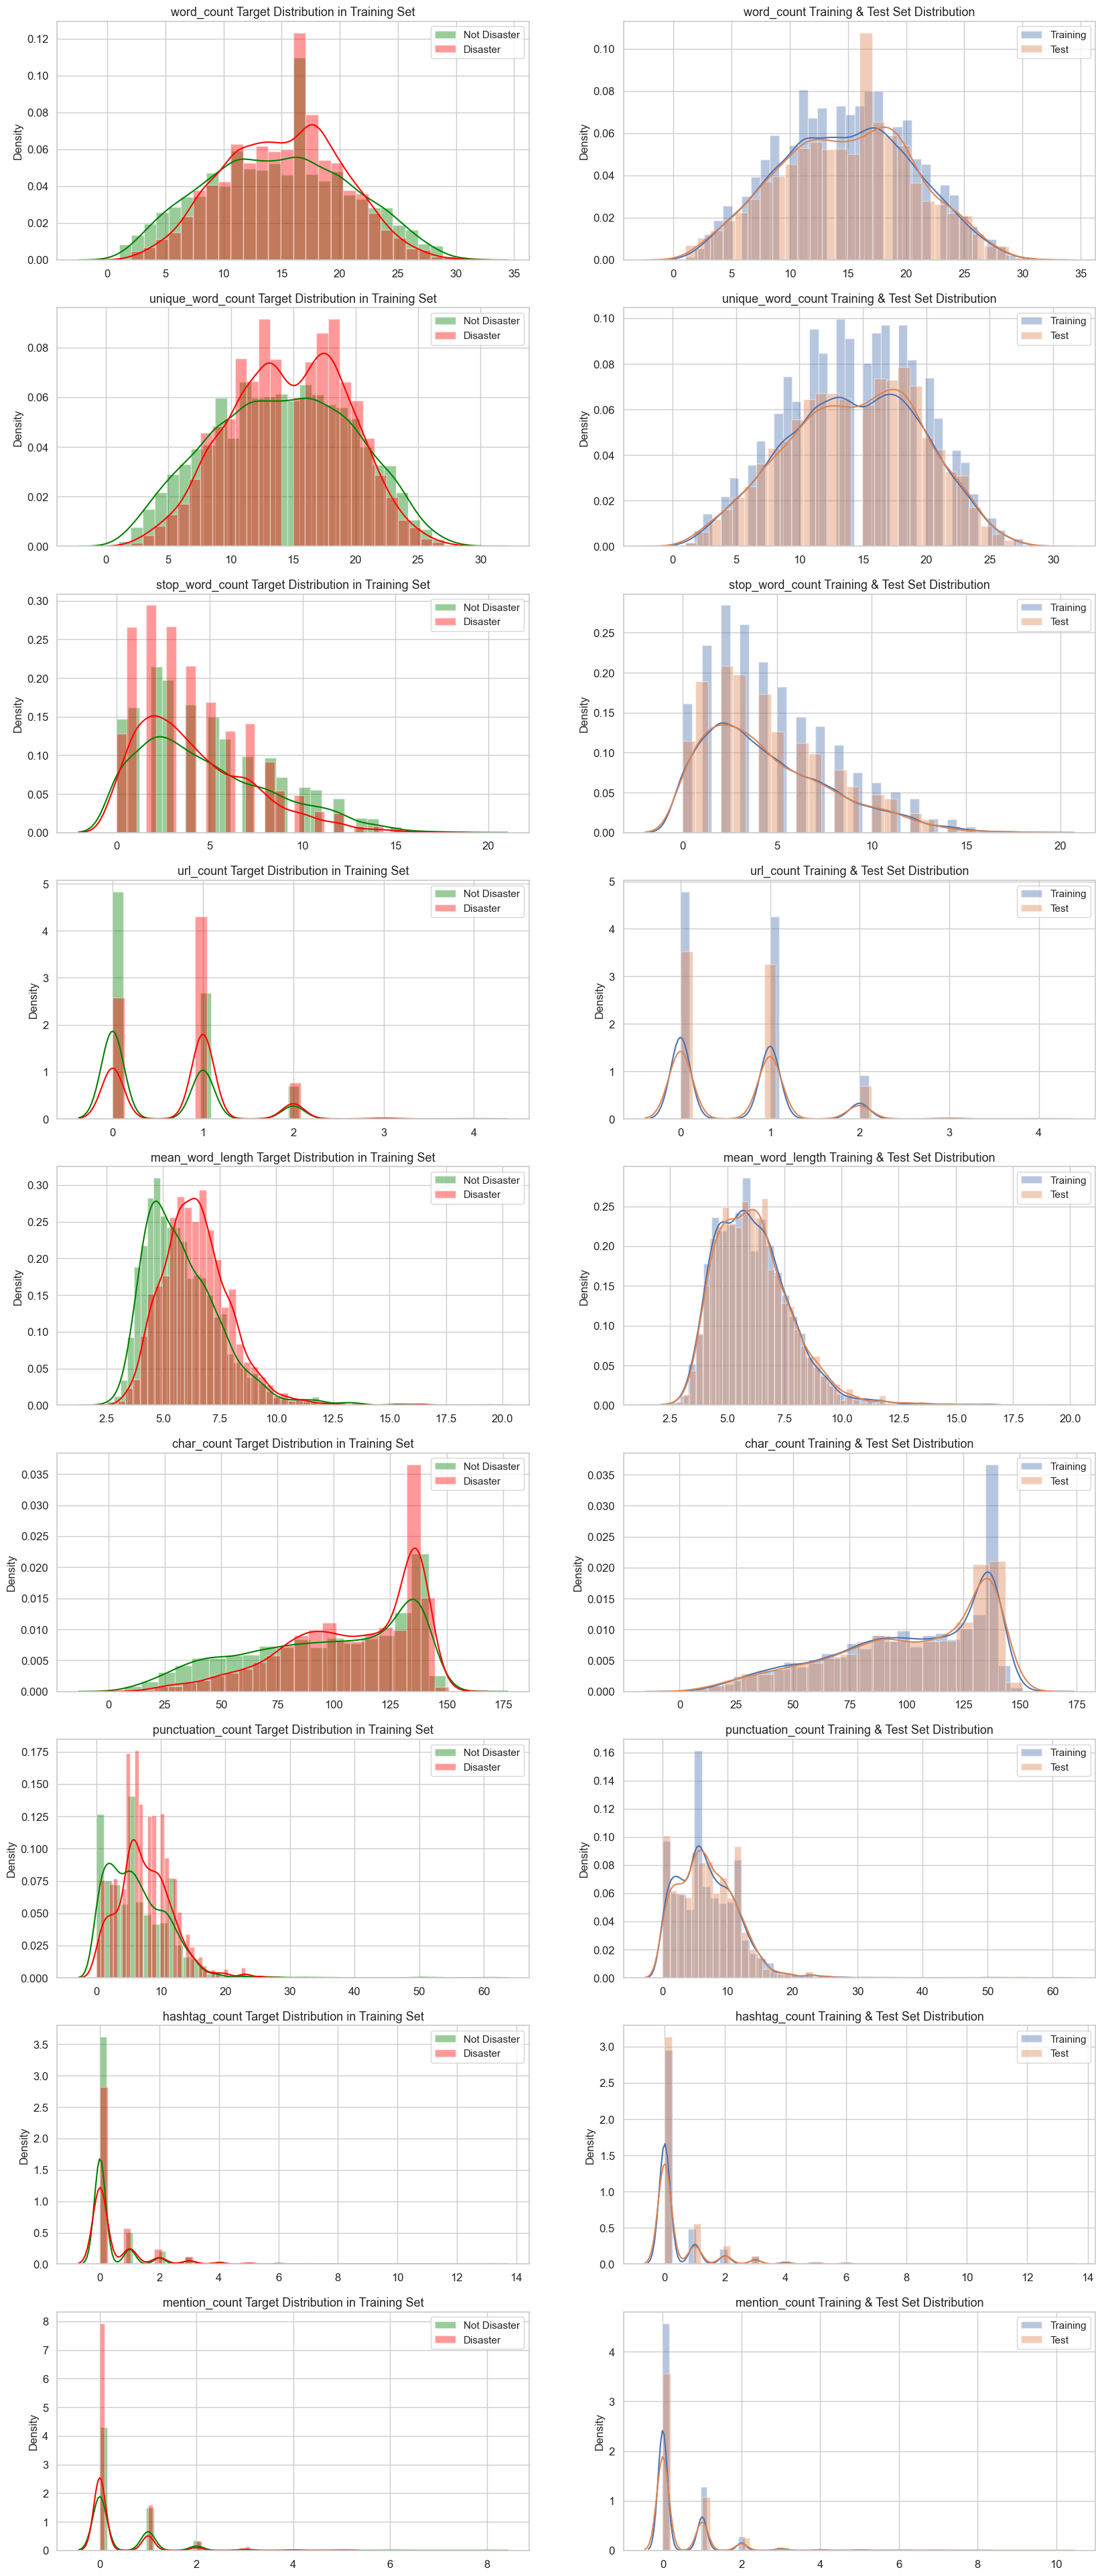

In [309]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

# Data cleaning and preprocessing

## Fill missing values

In [310]:
for df in [train , test]:
    for e in ['keyword', 'location']:
        df[e] = df[e].fillna('No_data')

## Removing stop words

In [311]:
nltk.download('wordnet')
nltk.download('stopwords')
stoplist = set(stopwords.words('english'))

test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
test.head()
train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
train.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,No_data,No_data,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0
1,4,No_data,No_data,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,No_data,No_data,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0
3,6,No_data,No_data,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0
4,7,No_data,No_data,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0


## Cleaning function
* removes URLs and special characters
* text lemmatization
* text stemming

In [312]:
def Clean(text):
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text) #remove URL
    
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>') #remove special character 
    
    text = re.sub(r"(?:\@)\w+", '', text)
    text=text.encode("ascii",errors="ignore").decode()
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
   
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

def stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text

def lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

In [313]:
train['text']=train['text'].apply(lambda x: Clean(x))
test['text']=test['text'].apply(lambda x: Clean(x))

## Text tokenizing

In [314]:
train['text_tokens'] = train['text'].apply(lambda x: word_tokenize(x))
test['text_tokens']  = train['text'].apply(lambda x: word_tokenize(x))

In [315]:
train.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_tokens
0,1,No_data,No_data,Our Deeds are the Reason of this earthquake Ma...,1,13,13,6,0,4.384615,69,1,1,0,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,No_data,No_data,Forest fire near La Ronge Sask Canada,1,7,7,0,0,4.571429,38,1,0,0,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,No_data,No_data,All residents asked to shelter in place are be...,1,22,20,11,0,5.090909,133,3,0,0,"[All, residents, asked, to, shelter, in, place..."
3,6,No_data,No_data,13000 people receive wildfires evacuation orde...,1,8,8,1,0,7.125000,65,2,1,0,"[13000, people, receive, wildfires, evacuation..."
4,7,No_data,No_data,Just got sent this photo from Ruby Alaska as s...,1,16,15,7,0,4.500000,88,2,2,0,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [316]:
train['text_tokens']=train['text'].apply(lambda x: stemmer(x))
test['text_tokens']=test['text'].apply(lambda x: stemmer(x))

train['text_tokens']=train['text'].apply(lambda x: lemmatizer(x))
test['text_tokens']=test['text'].apply(lambda x: lemmatizer(x))

In [317]:
train['text'][0]

'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all'

In [318]:
train['text_tokens'][0]

['O',
 'u',
 'r',
 ' ',
 'D',
 'e',
 'e',
 'd',
 's',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'R',
 'e',
 'a',
 's',
 'o',
 'n',
 ' ',
 'o',
 'f',
 ' ',
 't',
 'h',
 'i',
 's',
 ' ',
 'e',
 'a',
 'r',
 't',
 'h',
 'q',
 'u',
 'a',
 'k',
 'e',
 ' ',
 'M',
 'a',
 'y',
 ' ',
 'A',
 'L',
 'L',
 'A',
 'H',
 ' ',
 'F',
 'o',
 'r',
 'g',
 'i',
 'v',
 'e',
 ' ',
 'u',
 's',
 ' ',
 'a',
 'l',
 'l']

## Splitting data

In [319]:
feature=train['text']
target =train['target']

X_train, X_test, Y_train, Y_test = train_test_split(feature,target,test_size = 0.2,random_state =24)

In [320]:
X_train

7306    Climate Change CNN weather specialist warningw...
5627    Refugee Connections Indiegogo campaign will be...
3231    Want to work in Tarzana CA? View our latest op...
7121    Slow clap for this pilot Dramatic Video Shows ...
3429    Learn How I Gained Access To The Secrets Of Th...
                              ...                        
3473    Around 10 injured in explosion in chemical par...
343     Youre on stage now! Right under the lights! Is...
6336    3 excessive engine failure rate significant ma...
899     Bloody hell what a day I havent even really do...
4514     Did you see hurricane guillermo with MeteoEarth?
Name: text, Length: 6090, dtype: object

# Modeling

## Vectorising and fiting the data
**vectorizer** : it will do all three steps at once. Under the hood, it computes the word counts, IDF values, and TF-IDF scores all using the same data set\
**transformer**: it will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency values and only then compute the TFIDF scores.\
Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.\
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [321]:
vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b' ,ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
trainfeature = tfidf.fit_transform(vectorized)

In [322]:
TFIDF= TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=11000, 
                       norm='l2',
                       sublinear_tf=True)

In [323]:
TrainFeat_= TFIDF.fit_transform(X_train)

In [324]:
TestFeat_ = TFIDF.transform(X_test)

## Build and test models

We used 4 models in this work:
* Naive Bayes
* Logisctic regression
* SVM
* Random forest
---
Let's describe every of them, as well as accuracy metrics used.\
# 1. Naive Bayes
It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. 
![image](NB.jpg)
# 2. Logictic regression
Logistic Regression measures the relationship between the dependent variable (target label to predict) and the one or more independent variables (features), by estimating probabilities using it’s underlying logistic function.\
These probabilities must then be transformed into binary values in order to actually make a prediction. This is the task of the logistic function, also called the sigmoid function. The Sigmoid-Function is an S-shaped curve that can take any real-valued number and map it into a value between the range of 0 and 1, but never exactly at those limits. This values between 0 and 1 will then be transformed into either 0 or 1 using a threshold classifier.
![image](LR.png)
# 3. Random forest
A decision tree is a Machine Learning algorithm capable of fitting complex datasets and performing both classification and regression tasks. The idea behind a tree is to search for a pair of variable-value within the training set and split it in such a way that will generate the "best" two child subsets. The goal is to create branches and leafs based on an optimal splitting criteria, a process called tree growing. Specifically, at every branch or node, a conditional statement classifies the data point based on a fixed threshold in a specific variable, therefore splitting the data. To make predictions, every new instance starts in the root node (top of the tree) and moves along the branches until it reaches a leaf node where no further branching is possible.
![image](RF.png)
Random Forests are trained via the bagging method. Bagging or Bootstrap Aggregating, consists of randomly sampling subsets of the training data, fitting a model to these smaller data sets, and aggregating the predictions. This method allows several instances to be used repeatedly for the training stage given that we are sampling with replacement. Tree bagging consists of sampling subsets of the training set, fitting a Decision Tree to each, and aggregating their result.

In relation to sklearn:

A random forest is a collection of random decision trees (of number n_estimators in sklearn). What you need to understand is how to build one random decision tree.

Roughly speaking, to build a random decision tree you start from a subset of your training samples. At each node you will draw randomly a subset of features (number determined by max_features in sklearn). For each of these features you will test different thresholds and see how they split your samples according to a given criterion (generally entropy or gini, criterion parameter in sklearn). Then you will keep the feature and its threshold that best split your data and record it in the node. When the construction of the tree ends (it can be for different reasons: maximum depth is reached (max_depth in sklearn), minimum sample number is reached (min_samples_leaf in sklearn) etc.) you look at the samples in each leaf and keep the frequency of the labels. As a result, it is like the tree gives you a partition of your training samples according to meaningful features.

As each node is built from features taken randomly, you understand that each tree built in this way will be different. This contributes to the good compromise between bias and variance.

Then in testing mode, a test sample will go through each tree, giving you label frequencies for each tree. The most represented label is generally the final classification result.
# 4. SVM
A support-vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin, the lower the generalization error of the classifier.
![image](SVM.png)
# 5. Understanding the metrics
1. True Positives (TP): True positives are the cases when the actual class of the data point was 1(True) and the predicted is also 1(True) Ex: The case where a person is actually having cancer(1) and the model classifying his case as cancer(1) comes under True positive.

2. True Negatives (TN): True negatives are the cases when the actual class of the data point was 0(False) and the predicted is also 0(False

3. False Positives (FP): False positives are the cases when the actual class of the data point was 0(False) and the predicted is 1(True). False is because the model has predicted incorrectly and positive because the class predicted was a positive one. (1)

4. False Negatives (FN): False negatives are the cases when the actual class of the data point was 1(True) and the predicted is 0(False). False is because the model has predicted incorrectly and negative because the class predicted was a negative one. (0)
## Accuracy
Accuracy in classification problems is the number of correct predictions made by the model over all kinds predictions made.
![image](acc.png)
## Precision
Precision talks about how precise/accurate the model is out of those predicted positive, how many of them are actual positive. 
![image](prec.png)
## Recall
What percent of the positive cases did the model catch (predicted positive) amongst all positive cases. Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive. 
![image](recall.png)
## False Positive rate
False Positive Rate = False Positives / (False Positives + True Negatives) 
## F-1 Score
F1 score (also F-score or F-measure) is a measure of a test's accuracy. It considers both the precision p and the recall r of the test to compute the score: p is the number of correct positive results divided by the number of all positive results returned by the classifier, and r is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive). The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. 
![image](f1.png)
## ROC (receiver operating characteristics) curve
A curve of true positive rate vs. false positive rate at different classification thresholds.
## AUROC (Area under ROC)
An evaluation metric that considers all possible classification thresholds.
The Area Under the ROC curve is the probability that a classifier will be more confident that a randomly chosen positive example is actually positive than that a randomly chosen negative example is positive.

# Naive Bayes

In [325]:
classifier = MultinomialNB(alpha=1,
                          fit_prior=False)
classifier.fit(TrainFeat_,Y_train)

test_pred= classifier.predict(TestFeat_)
accuracy = accuracy_score(Y_train, classifier.predict(TrainFeat_))
accuracy

0.8850574712643678

In [326]:
testing_accuracy = accuracy_score(Y_test, test_pred)
testing_accuracy

0.8102429415627052

In [327]:
print(classification_report(Y_test, test_pred))
print("ROC AUC score is: ",roc_auc_score(Y_test,test_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       875
           1       0.82      0.71      0.76       648

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

ROC AUC score is:  0.7966234567901235


<AxesSubplot:>

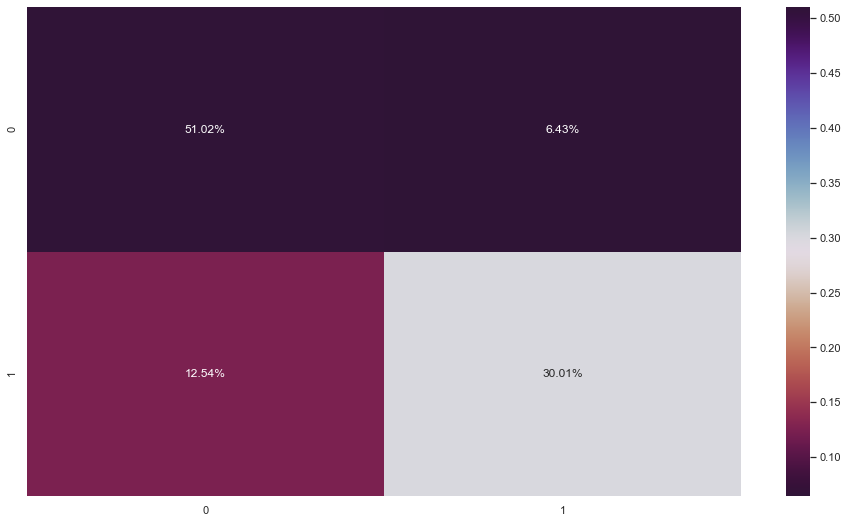

In [328]:
sns.heatmap(confusion_matrix(Y_test, test_pred)/np.sum(confusion_matrix(Y_test, test_pred)),
            annot=True, fmt='.2%', cmap='twilight_shifted_r')

In [329]:
tvectorizer=TFIDF.transform( test['text']).toarray()
last_predi = classifier.predict(tvectorizer)

results    = pd.DataFrame()

results['id'] = test['id']
results['target'] = last_predi

In [330]:
results

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [331]:
result = results.to_csv('Results/Naive_bayes.csv',index = False)

# Logistic regression

In [332]:
classifier = LogisticRegression(tol=1e-7,
                               C=2,
                               fit_intercept=True,
                               class_weight=None)
classifier.fit(TrainFeat_,Y_train)

test_pred= classifier.predict(TestFeat_)
accuracy = accuracy_score(Y_train, classifier.predict(TrainFeat_))
accuracy

0.9077175697865353

In [333]:
testing_accuracy = accuracy_score(Y_test, test_pred)
testing_accuracy

0.8214051214707814

In [334]:
print(classification_report(Y_test, test_pred))
print("ROC AUC score is: ",roc_auc_score(Y_test,test_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       875
           1       0.82      0.74      0.78       648

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

ROC AUC score is:  0.8113421516754851


<AxesSubplot:>

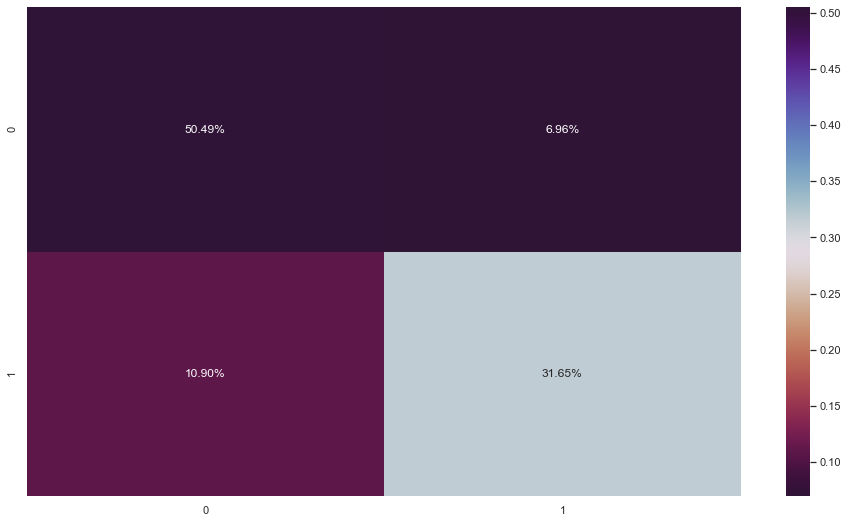

In [335]:
sns.heatmap(confusion_matrix(Y_test, test_pred)/np.sum(confusion_matrix(Y_test, test_pred)),
            annot=True, fmt='.2%', cmap='twilight_shifted_r')

In [336]:
tvectorizer=TFIDF.transform( test['text']).toarray()
last_predi = classifier.predict(tvectorizer)

results    = pd.DataFrame()

results['id'] = test['id']
results['target'] = last_predi

In [337]:
results

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [338]:
result = results.to_csv('Results/Logistic_Regression.csv',index = False)

# Random forest

In [339]:
classifier = RandomForestClassifier(n_estimators=150)
classifier.fit(TrainFeat_,Y_train)

test_pred= classifier.predict(TestFeat_)
accuracy = accuracy_score(Y_train, classifier.predict(TrainFeat_))
accuracy

0.9793103448275862

In [340]:
testing_accuracy = accuracy_score(Y_test, test_pred)
testing_accuracy

0.7957977675640184

In [341]:
print(classification_report(Y_test, test_pred))
print("ROC AUC score is: ",roc_auc_score(Y_test,test_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       875
           1       0.82      0.67      0.74       648

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

ROC AUC score is:  0.7794479717813051


<AxesSubplot:>

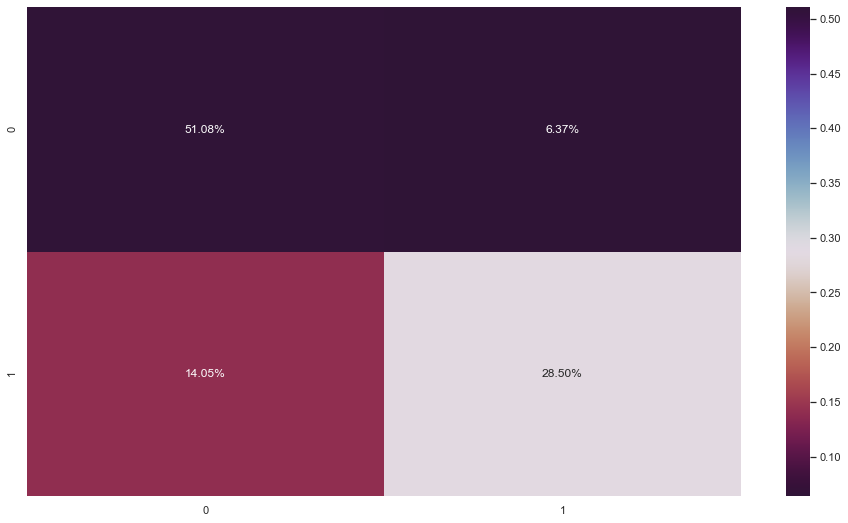

In [342]:
sns.heatmap(confusion_matrix(Y_test, test_pred)/np.sum(confusion_matrix(Y_test, test_pred)),
            annot=True, fmt='.2%', cmap='twilight_shifted_r')

In [343]:
tvectorizer=TFIDF.transform( test['text']).toarray()
last_predi = classifier.predict(tvectorizer)

results    = pd.DataFrame()

results['id'] = test['id']
results['target'] = last_predi

In [344]:
results

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [345]:
result = results.to_csv('Results/Random_forest.csv',index = False)

# SVM

In [346]:
classifier = SVC(C=1,
                kernel='rbf',
                gamma='scale',
                shrinking=True,
                probability=True,
                tol=1e-3,
                class_weight='balanced')
classifier.fit(TrainFeat_,Y_train)

test_pred= classifier.predict(TestFeat_)
accuracy = accuracy_score(Y_train, classifier.predict(TrainFeat_))
accuracy

0.9660098522167487

In [347]:
testing_accuracy = accuracy_score(Y_test, test_pred)
testing_accuracy

0.8214051214707814

In [348]:
print(classification_report(Y_test, test_pred))
print("ROC AUC score is: ",roc_auc_score(Y_test,test_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       875
           1       0.82      0.74      0.78       648

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

ROC AUC score is:  0.8111419753086421


<AxesSubplot:>

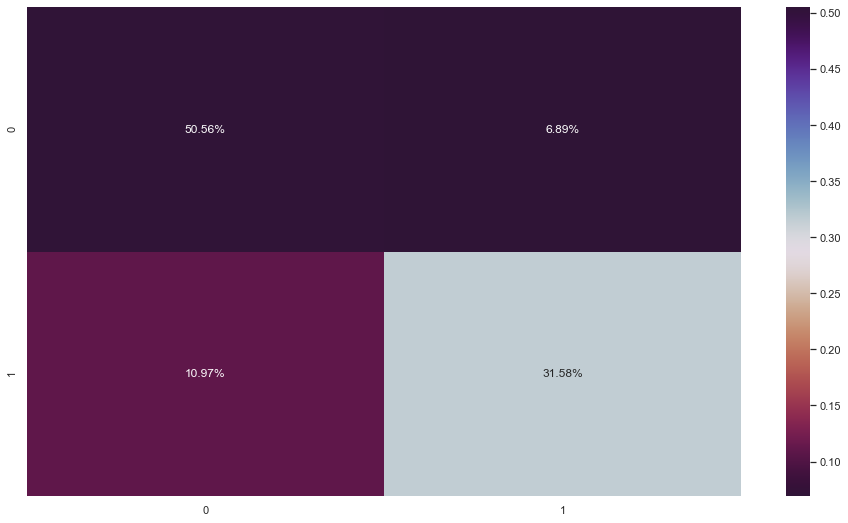

In [349]:
sns.heatmap(confusion_matrix(Y_test, test_pred)/np.sum(confusion_matrix(Y_test, test_pred)),
            annot=True, fmt='.2%', cmap='twilight_shifted_r')

In [350]:
tvectorizer=TFIDF.transform( test['text']).toarray()
last_predi = classifier.predict(tvectorizer)

results    = pd.DataFrame()

results['id'] = test['id']
results['target'] = last_predi

In [351]:
results

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [352]:
result = results.to_csv('Results/SVM.csv',index = False)

# Kaggle score
![image](result.png)

## Metrics and score comparison
* Naive Bayes
    * AUC ROC - 0.7966
    * Kaggle - 0.7956
* Logistic Regression
    * AUC ROC - 0.8113
    * Kaggle - 0.7934
* Random Forest
    * AUC ROC - 0.7794
    * Kaggle - 0.78087
* SVM
    * AUC ROC - 0.8111
    * Kaggle - 0.0.7962

As we can see, values are laying within statistical error